In [1]:
import os
import re
import time
import pickle
import numpy as np
import pandas as pd
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

import spacy
from gensim.models import Word2Vec

from nltk.corpus import stopwords
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

from functions import data_prep
from functions import merge_df_cols

In [17]:
# Prepare dfs
df = pd.read_csv('data/pepper_dump_19_06_2024.csv')

# BioPic Model
df_eval_c = pd.read_csv('data/pepper_biopyschosocialenv_manually_labeled_responses_redacted.csv')

# Sentiment
#df_eval_c = pd.read_csv('data/peppers_manually_labeled_response_redacted.csv')

df_eval_c['created_at'] = pd.to_datetime(df_eval_c['created_at'], errors='coerce')
df_eval_c['created_at'] = df_eval_c['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S')

# merge all cols to df_eval_c on FsDaily_id
additional_columns = [col for col in df.columns if col not in df_eval_c.columns]
df_eval_c = df_eval_c.merge(df[['FsDaily_id'] + additional_columns], on='FsDaily_id', how='inner')

# Apply preprocessing
df = data_prep(df)
df_eval = data_prep(df_eval_c)

# Merge df
data_df = merge_df_cols(df_eval)
#data_df

C:\Users\lmunz\AppData\Local\Temp\ipykernel_664\569604983.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_eval_c['created_at'] = pd.to_datetime(df_eval_c['created_at'], errors='coerce')


In [14]:
#data_df['manual_label'].value_counts()

In [15]:
# Remove duplicates
data_df.drop_duplicates(subset=["text"], inplace=True)
#data_df['manual_label'].value_counts()

In [13]:
# Vor dem ersten Gebrauch musst du die Stopwörter und die Punktuation herunterladen
nltk.download('stopwords')
nltk.download('punkt')

# Laden des Spacy-Sprachmodells für Deutsch
nlp = spacy.load('de_core_news_md')

def preprocess_text(text):
    tokens = word_tokenize(text, language='german')
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]

    stop_words = set(stopwords.words('german'))
    tokens = [word for word in tokens if word not in stop_words]
    
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc]
    
    preprocessed_text = ' '.join(lemmas)

    return preprocessed_text


data_df['text'] = data_df['text'].apply(preprocess_text)
#data_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lmunz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lmunz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\ProgramData\anaconda3\envs\train_model_new\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'de_core_news_md' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


---
# Naive Bayes Classifier for Multinomial Models

In [6]:
X = data_df.text
y = data_df.manual_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

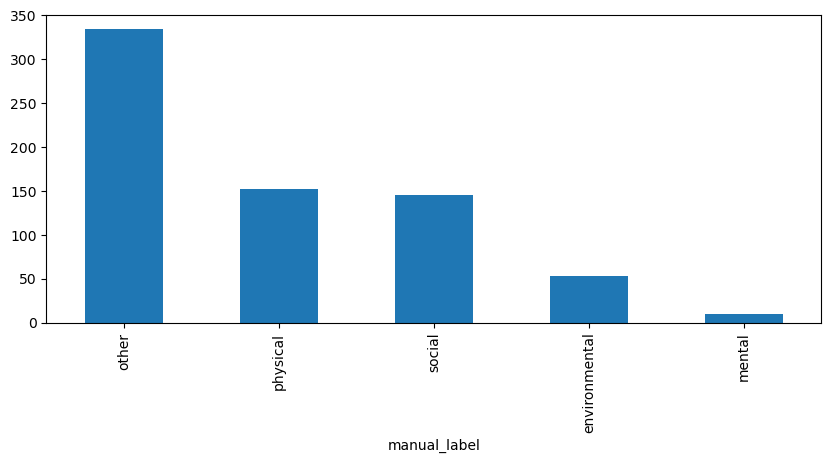

In [7]:
my_tags = ['other','physical','mental','environmental','social']
# plt.figure(figsize=(10,4))
# data_df.manual_label.value_counts().plot(kind='bar');

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6602870813397129
               precision    recall  f1-score   support

        other       1.00      0.21      0.35        14
     physical       0.00      0.00      0.00         7
       mental       0.61      0.98      0.76       109
environmental       0.89      0.44      0.59        39
       social       0.85      0.28      0.42        40

     accuracy                           0.66       209
    macro avg       0.67      0.38      0.42       209
 weighted avg       0.72      0.66      0.61       209


C:\ProgramData\anaconda3\envs\train_model_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\train_model_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\train_model_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

---
# Linear Support Vector Machine

In [9]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7559808612440191
               precision    recall  f1-score   support

        other       0.92      0.79      0.85        14
     physical       1.00      0.29      0.44         7
       mental       0.76      0.90      0.82       109
environmental       0.72      0.59      0.65        39
       social       0.71      0.60      0.65        40

     accuracy                           0.76       209
    macro avg       0.82      0.63      0.68       209
 weighted avg       0.76      0.76      0.75       209


---
# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7703349282296651
               precision    recall  f1-score   support

        other       0.92      0.79      0.85        14
     physical       1.00      0.29      0.44         7
       mental       0.75      0.94      0.83       109
environmental       0.84      0.54      0.66        39
       social       0.74      0.62      0.68        40

     accuracy                           0.77       209
    macro avg       0.85      0.63      0.69       209
 weighted avg       0.78      0.77      0.76       209


C:\ProgramData\anaconda3\envs\train_model_new\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---
# Word2vec and Logistic Regression Fasttext embeddings

Download german model:
- https://fasttext.cc/docs/en/crawl-vectors.html

In [11]:

from gensim.models.fasttext import load_facebook_model

model_path = 'models/cc.de.300.vec.gz'
model = load_facebook_model(model_path)

word_vector = model['Haus']
print(word_vector)

FileNotFoundError: [Errno 2] No such file or directory: 'models/cc.de.300.vec.gz'

In [ ]:
import numpy as np
import gensim
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv[word])
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='german'):
        for word in nltk.word_tokenize(sent, language='german'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens


train, test = train_test_split(data_df, test_size=0.3, random_state=42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(wv, train_tokenized)
X_test_word_average = word_averaging_list(wv, test_tokenized)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['manual_label'])
y_pred = logreg.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test['manual_label']))
print(classification_report(test['manual_label'], y_pred, target_names=my_tags))
